In [1]:
from PIL import Image
import cv2 
from IPython.display import display
from functools import reduce
import numpy as np
from scipy.ndimage import interpolation as inter
import pytesseract
import re

print_img = lambda x: display(Image.fromarray(cv2.cvtColor(x, cv2.COLOR_BGR2RGB)))  

In [2]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_TOZERO + cv2.THRESH_OTSU)[1] # was THRESH_BINARY INITIALLY
    
#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((3,3),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

def correct_skew(image, delta=1, limit=5, input_is_gray=False):
    def determine_score(arr, angle):
        data = inter.rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2)
        return histogram, score
    if input_is_gray:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray=image
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)[1] 

    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        histogram, score = determine_score(thresh, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, \
              borderMode=cv2.BORDER_REPLICATE)
    
    return rotated
    return best_angle, rotated

In [7]:
input_img = cv2.imread('3.png')

In [8]:
preprocessing_functions = [ get_grayscale,         correct_skew,]
output_img = reduce(lambda x,y: y(x), preprocessing_functions, input_img)

In [10]:
print(output_img)

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


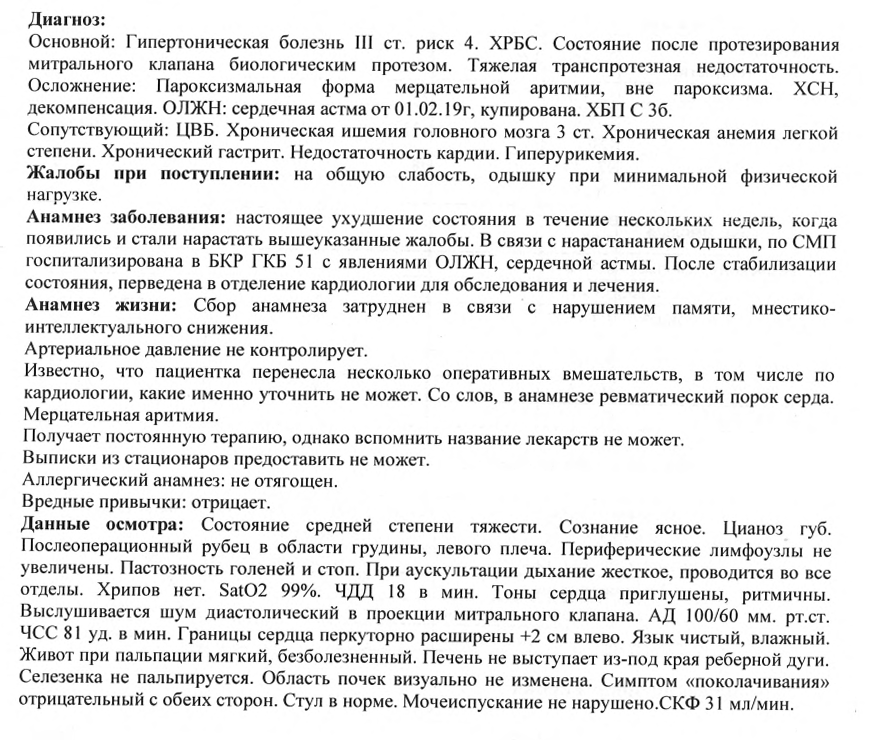

In [9]:
print_img(output_img)

In [144]:
def prettier_text(input_text):
    output_text = input_text
    output_text = ' '.join([i for i in output_text.split(' ') if i]) # remove consecutive spaces
    
    # remove spaces near line breaks
    output_text = list(output_text)
    for i in range(1, len(output_text)):
        if output_text[i] == '\n' and output_text[i-1] == ' ':
            output_text[i-1] = '' #
    output_text = ''.join(output_text)
    
    # remove consecutive line breaks
    output_text = '\n'.join([i for i in output_text.split('\n') if i]) # remove consecutive spaces
        
    return output_text

In [145]:
raw_output = pytesseract.image_to_string(output_img, lang='rus+eng',)
print(prettier_text(raw_output))

Диагноз:
Основной: Гипертоническая болезнь Ш ст. риск 4. ХРБС. Состояние после протезирования
митрального клапана биологическим протезом. Тяжелая транспротезная недостаточность.
Осложнение: Пароксизмальная форма мерцательной аритмии, вне пароксизма. ХСН,
декомпенсация. ОЛЖН: сердечная астма от 01.02.19г, купирована. ХБП С 36.
Сопутствующий: ЦВБ. Хроническая ишемия головного мозга 3 ст. Хроническая анемия легкой
степени. Хронический гастрит. Недостаточность кардии. Гиперурикемия.
Жалобы при поступлении: на общую слабость, одышку при минимальной физической
нагрузке.
Анамнез заболевания: настоящее ухудшение состояния в течение нескольких недель, когда
появились и стали нарастать вышеуказанные жалобы. В связи с нарастананием одышки, по СМИ
госпитализирована в БКР ГКБ 51 с явлениями ОЛЖН, сердечной астмы. После стабилизации
состояния, перведена в отделение кардиологии для обследования и лечения.
Анамнез жизни: Сбор анамнеза затруднен в связи с нарушением памяти, мнестико-
интеллектуального 